# Howdy 🤠 
## In this notebook i'll be doing **Sentiment Analysis** with **LSTM (Long short term memory)**
### if you aren't familiar with **Sentiment Analysis** : it's the process of identifying and categorizing opinions expressed in a piece of text

### Anyway enough with the yapping and let's cook 😗

<img src='https://uploads.dailydot.com/2024/04/let-him-cook-meme-.jpg?q=65&auto=format&w=1600&ar=2:1&fit=crop' height = 420 width = 620></img>

## Importing libs and getting the dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [12]:
# loading the dataset

file_path = r"/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv"
df = pd.read_csv(file_path , header = None ,names=['number' , 'Border' , 'label' , 'message']) # Adjusting the column names

### in this dataset we should build a model that can predict whether the sentence has a -ve or +ve or neutral effect based on the user's messages !

## Now let's discover the data and get to know it !

In [13]:
display(df.head())

,number,Border,label,message
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [14]:
display(df['label'].value_counts())

label
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

## Okay let's drop the Useless columns

In [15]:
df.drop(['Border' , 'number'] , axis=1 , inplace = True)

In [19]:
# Shape ? 

df.shape

(74682, 2)

In [17]:
# Null values ? 

df.isnull().sum()

label        0
message    686
dtype: int64

## Let's Drop the null rows !

In [21]:
df.dropna(inplace = True)

In [22]:
df.shape

(73996, 2)

<img src='https://media1.tenor.com/m/UGLkFpDi-vsAAAAC/avada-kedavra.gif' height = 420 width = 620></img>

### That's good 
## Now let's start with the **Pre-processing** ⚙️ 
### 1st - LowerCasing text

In [23]:
df['message'] = df['message'].str.lower()

df.head()

,label,message
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


### 2 - Removing HTML tags ! 

In [24]:
from bs4 import BeautifulSoup

def remove_html(text):

    clean_text = BeautifulSoup(text , 'html.parser')

    return clean_text.get_text()

In [25]:
df['message'] = df['message'].apply(remove_html)

display(df['message'].head(2))

<ipython-input-24-e5d715a31394>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(text , 'html.parser')


0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
Name: message, dtype: object

### 3 - Removing URLs (using regular expression (regex)

In [26]:
import re

def clean_url(text):
    
    return re.sub(r'http\S+|www\S+', '', text)

In [27]:
df['message'] = df['message'].apply(clean_url)

df.head()

,label,message
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


### 4 - Removing punctuation

In [28]:
def remove_punctuation(text):
    
    return re.sub(r'[^\w\s]', '', text)

In [29]:
df['message'] = df['message'].apply(remove_punctuation)

df.head()

,label,message
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you all
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


### 5 - Removing Stop words

#### Stop words like : "the," "is," "and," "in," "on" don't add much of a value to the model in this task

In [31]:
import spacy

nlp = spacy.load("en_core_web_sm")

def remove_stopwords(text):
    if not isinstance(text, str):  # Handle non-string inputs
        return text
        
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [32]:
df['message'] = df['message'].apply(remove_stopwords)

In [41]:
df.head()

,label,message
0,Positive,m getting borderlands murder
1,Positive,coming borders kill
2,Positive,m getting borderlands kill
3,Positive,m coming borderlands murder
4,Positive,m getting borderlands 2 murder


### 6 - Removing Emojis !

In [43]:
import emoji

def remove_emojis(text):
    return emoji.demojize(text)

df['message'] = df['message'].apply(remove_emojis)

### 7 - Lemmatization
#### changing the word back to its roots like : playing -> play , ate -> eat

In [44]:
def lemmatize_text(text):
    
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

df['message_lemmatized'] = df['message'].apply(lemmatize_text)

In [45]:
df.head()

,label,message,message_lemmatized
0,Positive,m getting borderlands murder,m get borderland murder
1,Positive,coming borders kill,come border kill
2,Positive,m getting borderlands kill,m get borderland kill
3,Positive,m coming borderlands murder,m come borderland murder
4,Positive,m getting borderlands 2 murder,m get borderland 2 murder


## We finished the cleaning part ! Hooray 🥳
### now let's put all what we've done to process incoming input in the future !

In [46]:
def clean_text(text):
    if not isinstance(text, str):  # Handle non-string inputs
        return text
    
    text = text.lower()  # 1️⃣ Convert to lowercase
    text = remove_html(text)  # 2️⃣ Remove HTML
    text = clean_url(text)  # 3️⃣ Remove URLs
    text = remove_punctuation(text)  # 4️⃣ Remove punctuation
    text = remove_stopwords(text)  # 5️⃣ Remove stopwords
    text = remove_emojis(text)  # 6️⃣ Remove emojis
    text = lemmatize_text(text)  # 7️⃣ Lemmatization
    
    return text

In [48]:
# let's give it a test !

new_text = "Heyyyy!!! 😊 Check this out: https://example.com <b>Awesome!</b>"
cleaned_text = clean_text(new_text)
print(cleaned_text)

heyyyy    check    awesome


## Word Cloud

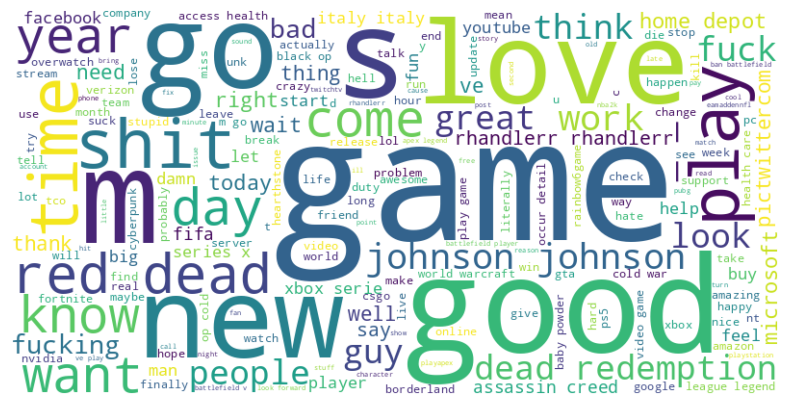

In [49]:
from wordcloud import WordCloud

# Convert the column to a single string
text = df['message_lemmatized'].astype(str).str.cat(sep=" ")

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Now let's a word cloud of the +ve sentences and the -ve according to the data

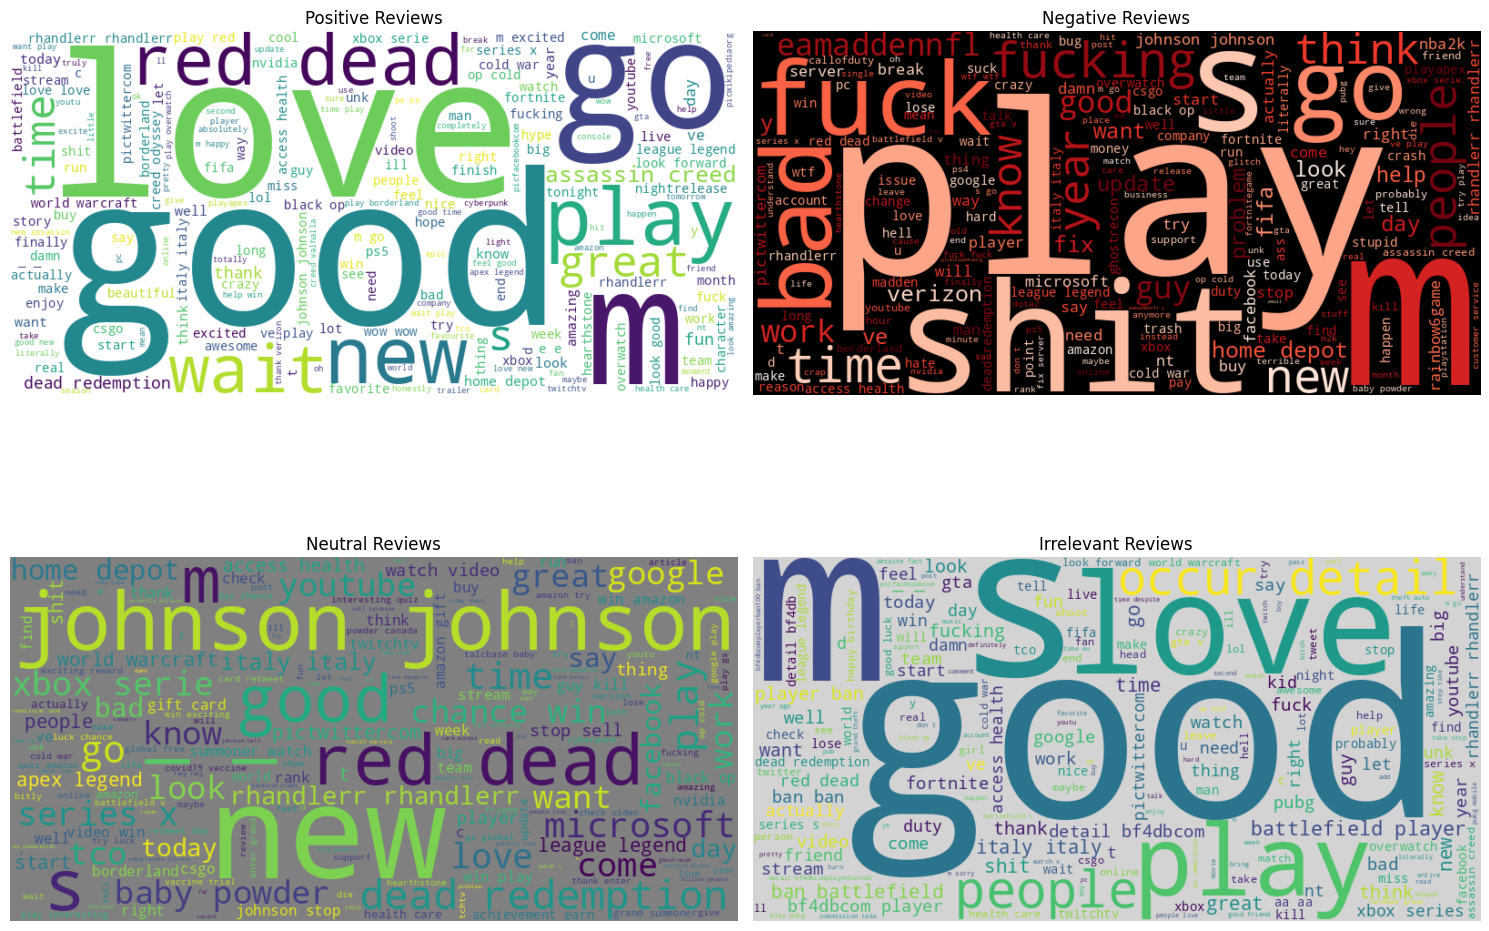

In [54]:
# Combine text data for each sentiment category
positive_text = " ".join(df[df["label"] == "Positive"]["message_lemmatized"])
negative_text = " ".join(df[df["label"] == "Negative"]["message_lemmatized"])
neutral_text = " ".join(df[df["label"] == "Neutral"]["message_lemmatized"])
irrelevant_text = " ".join(df[df["label"] == "Irrelevant"]["message_lemmatized"])

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='gray').generate(neutral_text)
irrelevant_wordcloud = WordCloud(width=800, height=400, background_color='lightgray').generate(irrelevant_text)

# Plot word clouds
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

ax[0, 0].imshow(positive_wordcloud, interpolation='bilinear')
ax[0, 0].set_title("Positive Reviews")
ax[0, 0].axis("off")

ax[0, 1].imshow(negative_wordcloud, interpolation='bilinear')
ax[0, 1].set_title("Negative Reviews")
ax[0, 1].axis("off")

ax[1, 0].imshow(neutral_wordcloud, interpolation='bilinear')
ax[1, 0].set_title("Neutral Reviews")
ax[1, 0].axis("off")

ax[1, 1].imshow(irrelevant_wordcloud, interpolation='bilinear')
ax[1, 1].set_title("Irrelevant Reviews")
ax[1, 1].axis("off")

plt.tight_layout()
plt.show()

## from this word cloud we can remove the word game as it's illogical to exist in every class !

In [53]:
df["message_lemmatized"] = df["message_lemmatized"].str.replace(r'\bgame\b', '', regex=True)

## Pre-Processing for the Target

In [69]:
# I'm going to mix the neutral class with the Irrelevant
df['label'] = df['label'].map({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [70]:
df['label'].value_counts()

label
2    30983
0    22358
1    20655
Name: count, dtype: int64

## Split the data
#### into ( train , test and validation data ) 
#### since that there's imbalance in the target i'm going to use stratified sampling

In [71]:
from sklearn.model_selection import train_test_split

X = df['message_lemmatized'] # feature matrix ( in this case it's just a vectore cause it's only one column)
y = df['label'] # target column

X_train1 , X_test , y_train1 , y_test = train_test_split(X,y , random_state = 42 , test_size = 0.2  , shuffle = True)
X_train , X_val , y_train , y_val = train_test_split(X_train1 , y_train1 , random_state = 42 , test_size = 0.15  , shuffle = True)

In [72]:
X_train.shape , X_val.shape , X_test.shape , y_train.shape , y_val.shape , y_test.shape

((50316,), (8880,), (14800,), (50316,), (8880,), (14800,))

## Tokenization 
#### Converting words into numerical tokens

In [57]:
import tensorflow as tf

In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = 'nothing')
tokenizer.fit_on_texts(X_train) # we call this method to build the tokenizer on the train data only to avoid data leakage !

In [74]:
#  returns the total number of documents (sentences) processed by the tokenizer
# just to make sure that all the sentences have been converted to tokens !

tokenizer.document_count

50316

### Conversion to sequence
#### used to convert each text in the data to sequences of integers based on the tokenizer's vocabulary

In [75]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

### Padding
#### we apply padding on the data to ensure that each sequence is the same length !

In [76]:
# finding the max length
max_len = max(len(tokens) for tokens in X_train_seq)
print("Maximum sequence length (maxlen):", max_len)


Maximum sequence length (maxlen): 99


In [77]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Perform padding on X_train and X_test sequences and X_val

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

In [78]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded[:1])
print("\nX_test_padded:")
print(X_test_padded[:1])
print("\nX_val_padded:")
print(X_val_padded[:1])

X_train_padded:
[[  32   93   63  304  684   32  393 1152  828    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]]

X_test_padded:
[[  14    6  440  125  113  700 1379 1100   76  113  377 3307    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  

### I was plannig to use Glove as a pretrained model for vector embeddings and then finetune it with my data
### but let's give training an embedding layer from scratch a try first !
### However with what we got so far we can train the model directly but LSTM works well with vector embeddings

In [79]:
# Define vocab size based on the tokenizer
vocab_size = len(tokenizer.word_index) + 1

print(vocab_size)

30921


## Model Building

In [84]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128 , return_sequences = True , dropout = 0.2 , recurrent_dropout = 0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64 , dropout = 0.2 , recurrent_dropout = 0.2)),
    tf.keras.layers.Dense(64 , activation='relu'  , kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(3 , activation = 'softmax')

])

In [85]:
# defining callbacks for Early stopping and changing the learning rate while training 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [86]:
# compiling the model 

# Compile Model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [87]:
with tf.device('/device:GPU:0'):
  # Train the Model
  history = model.fit(
      X_train_padded,  
      y_train,  
      validation_data=(X_val_padded, y_val),  # Validation set
      batch_size=32,  
      epochs=30,  
      callbacks=[early_stopping , reduce_lr],  # to Prevent overfitting
      verbose=1 
  )

Epoch 1/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 698s 437ms/step - accuracy: 0.6073 - loss: 0.8386 - val_accuracy: 0.7930 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 2/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 684s 435ms/step - accuracy: 0.8589 - loss: 0.3623 - val_accuracy: 0.8443 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 3/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 677s 430ms/step - accuracy: 0.9085 - loss: 0.2307 - val_accuracy: 0.8631 - val_loss: 0.3655 - learning_rate: 0.0010
Epoch 4/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 681s 433ms/step - accuracy: 0.9281 - loss: 0.1801 - val_accuracy: 0.8676 - val_loss: 0.3599 - learning_rate: 0.0010
Epoch 5/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 685s 436ms/step - accuracy: 0.9367 - loss: 0.1519 - val_accuracy: 0.8784 - val_loss: 0.3594 - learning_rate: 0.0010
Epoch 6/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 681s 433ms/step - accuracy: 0.9446 - loss: 0.1301 - val_accuracy: 0.8784 - val_loss: 0.3793 - learning_rate: 0.0010
Epoch 7/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 680s 432ms

In [88]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 99, 100)             │       3,092,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 99, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,498,199 (40.05 MB)

 Trainable params: 3,499,399 (13.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,998,800 (26.70 MB)

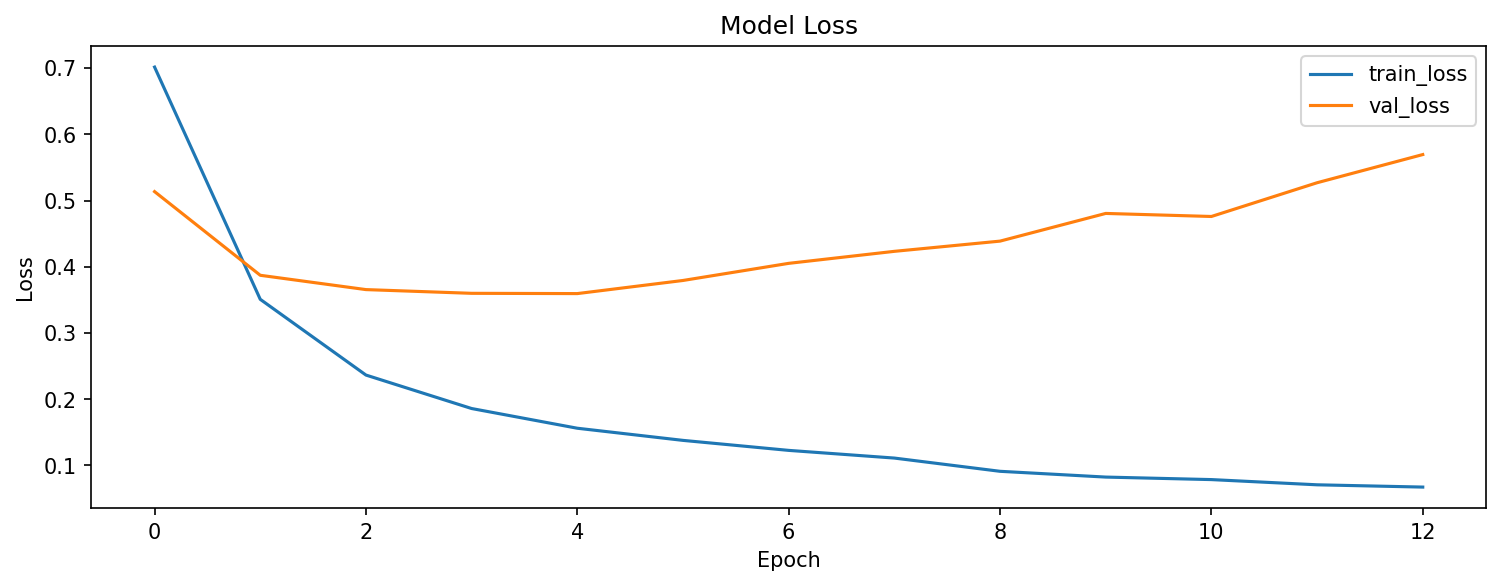

In [89]:

plt.figure(figsize=(12, 4), dpi=150)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


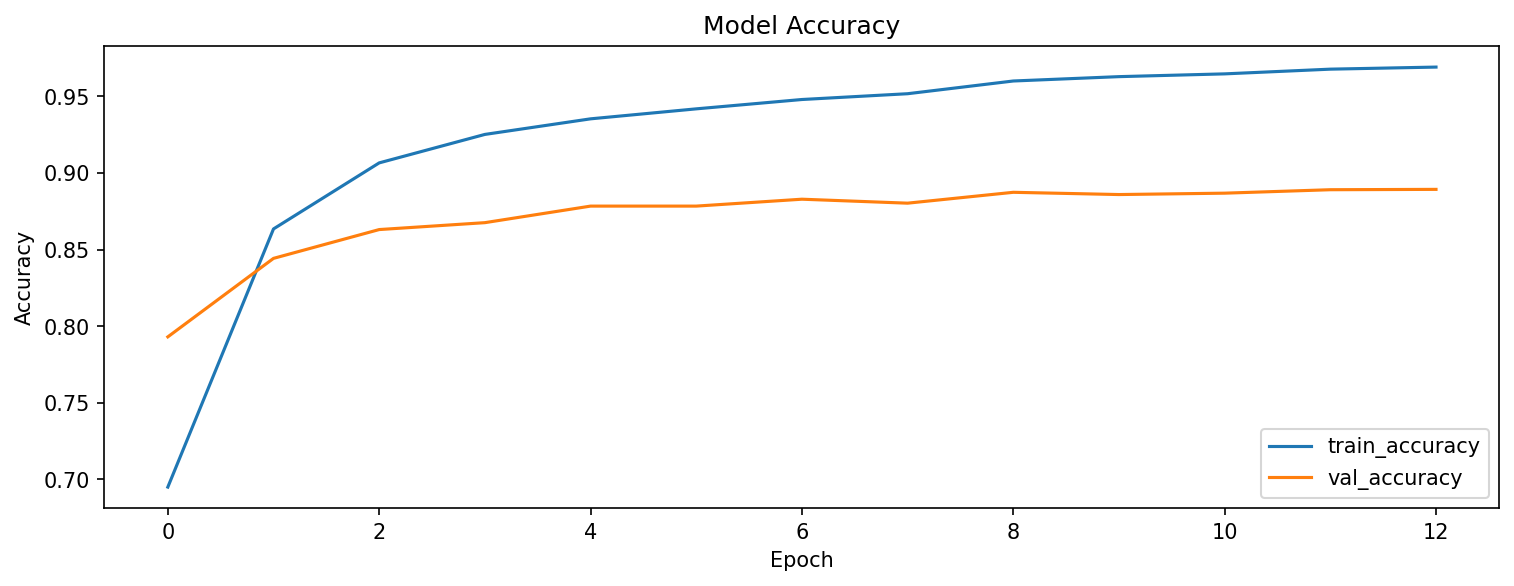

In [90]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Evaluation

In [92]:
# Get model predictions (probabilities)
y_probs = model.predict(X_test_padded)

# Converting probs into Binary values
y_pred = np.argmax(y_probs, axis=1)

463/463 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step


In [93]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

463/463 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.8722 - loss: 0.3712
Loss: 0.3634290397167206, Accuracy: 0.8758783936500549


## Confusion Matrix

In [96]:
from sklearn.metrics import confusion_matrix , classification_report

cfm = confusion_matrix(y_test , y_pred)

In [97]:
# classification report
report = classification_report(y_test, y_pred)

# the report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4380
           1       0.85      0.86      0.86      4119
           2       0.88      0.89      0.89      6301

    accuracy                           0.88     14800
   macro avg       0.88      0.87      0.87     14800
weighted avg       0.88      0.88      0.88     14800



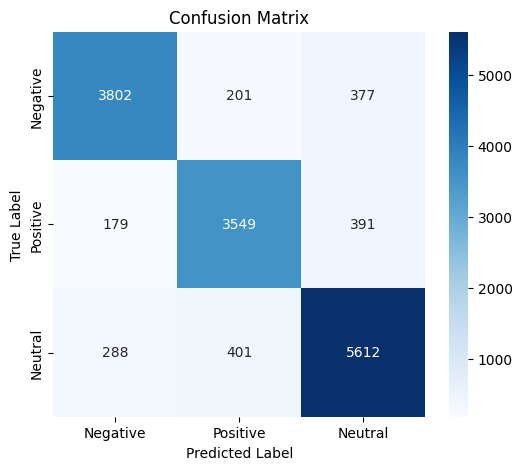

In [101]:
plt.figure(figsize=(6, 5))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative' , 'Positive' , 'Neutral'], yticklabels=['Negative' , 'Positive','Neutral'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### From the Confusion matrix we can conclude that the model is Okay !

<img src='https://media1.tenor.com/m/xZUiiLfAwzQAAAAC/walter-white-let-him-cook.gif' height = 420 width = 620></img>

## Saving the model and the tokenizer

In [102]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [103]:
# now the model 

model.save("LSTM_Sentiment_analysis.h5")

## Pre-Processing Pipeline for predictions

In [104]:
def preprocess_text(texts, tokenizer):
    """
    Preprocess new incoming text data.

    Args:
        texts (list of str): List of raw text inputs.
        tokenizer (Tokenizer): Pre-trained tokenizer.
        max_len (int): Maximum sequence length.

    Returns:
        np.array: Padded sequences ready for prediction.
    """
    # Convert text to sequences
    text_seq = tokenizer.texts_to_sequences(texts)
    
    # Apply padding
    text_padded = pad_sequences(text_seq, maxlen=max_len, padding="post")
    
    return text_padded

In [112]:
def Predict(text , model , tokenizer):
    
    text = [text]
    text = clean_text(text)
    text_padded =  preprocess_text(text , tokenizer)

    y_prob = model.predict(text_padded)
   
    y_pred = np.argmax(y_prob, axis=1)

    classes = ['Negative' , 'Positive' , 'Neutral']

    pred_class = classes[y_pred[0]]  # Get predicted class label
    pred_prob = y_prob[0][y_pred[0]] # get predicted prob


    return pred_class, pred_prob

## Loading the model
## Now if u want to use the model again without training it again
### you can simply load it with the tokenzier

In [106]:
# loading the tokenizer

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)


# Load the saved model
loaded_model = tf.keras.models.load_model('/kaggle/working/LSTM_Sentiment_analysis.h5')

In [121]:
new_text = "I'm Sad"

pred_class  , prob  = Predict(new_text , loaded_model , tokenizer)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [122]:
print(f"Class Prediction is : {pred_class} with Probabilty {prob}")

Class Prediction is : Negative with Probabilty 0.9179257154464722
